# Lab: Non-linear Modeling
In this lab, we re-analyze the `Wage` data considered in the
examples throughout this chapter, in order to illustrate the fact that
many of the complex non-linear fitting procedures discussed  can
be easily implemented in `R`.  We begin by loading the
`ISLR2` library, which contains the data.

In [1]:
library(ISLR2)
attach(Wage)

## Polynomial Regression and Step Functions
\def\caret{{^}}

We now examine how Figure 7.1 was produced. We first fit the model using the following command:

In [2]:
fit <- lm(wage ~ poly(age, 4), data = Wage)
coef(summary(fit))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),111.70361,0.7287409,153.283015,0.000000e+00
"poly(age, 4)1",447.06785,39.9147851,11.200558,1.484604e-28
"poly(age, 4)2",-478.31581,39.9147851,-11.983424,2.355831e-32
"poly(age, 4)3",125.52169,39.9147851,3.144742,1.678622e-03
"poly(age, 4)4",-77.91118,39.9147851,-1.951938,5.103865e-02


This syntax fits a linear model, using the `lm()` function, in order to predict `wage` using a fourth-degree polynomial in `age`: `poly(age, 4)`. The `poly()` command allows us to avoid having to write out a long formula with powers of `age`. The function returns a matrix whose columns are a basis of *orthogonal polynomials* , which essentially means that each column is a linear combination of the variables `age`, `age^2`,  `age^3` and `age^4`.

However, we can also use `poly()` to obtain `age`, `age^2`,  `age^3` and `age^4` directly, if we prefer. We can do this by using the `raw = TRUE` argument to the `poly()` function.
Later we   see that this does not affect the model in a meaningful way---though the choice of basis clearly affects the coefficient estimates, it does not affect the fitted values obtained.

In [3]:
fit2 <- lm(wage ~ poly(age, 4, raw = T), data = Wage)
coef(summary(fit2))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-1.841542e+02,6.004038e+01,-3.067172,0.0021802539
"poly(age, 4, raw = T)1",2.124552e+01,5.886748e+00,3.609042,0.0003123618
"poly(age, 4, raw = T)2",-5.638593e-01,2.061083e-01,-2.735743,0.0062606446
"poly(age, 4, raw = T)3",6.810688e-03,3.065931e-03,2.221409,0.0263977518
"poly(age, 4, raw = T)4",-3.203830e-05,1.641359e-05,-1.951938,0.0510386498


There are several other equivalent ways of fitting this model, which showcase the flexibility of the formula language in `R`. For example

In [4]:
fit2a <- lm(wage ~ age + I(age^2) + I(age^3) + I(age^4),
    data = Wage)
coef(fit2a)

(Intercept)           age      I(age^2)      I(age^3)      I(age^4) 
-1.841542e+02  2.124552e+01 -5.638593e-01  6.810688e-03 -3.203830e-05

This simply creates the polynomial basis functions on the fly, taking care to protect terms like `age^2` via the  function `I()` (the `^` symbol has a special meaning in formulas).

In [5]:
fit2b <- lm(wage ~ cbind(age, age^2, age^3, age^4),
    data = Wage)

This does the same more compactly, using the `cbind()` function for building a matrix from a collection of vectors; any function call such as `cbind()` inside a formula also serves as a wrapper.

We now create a grid of values for `age` at which we want predictions, and then call the generic `predict()` function, specifying that we want standard errors as well.

In [6]:
agelims <- range(age)
age.grid <- seq(from = agelims[1], to = agelims[2])
preds <- predict(fit, newdata = list(age = age.grid),
    se = TRUE)
se.bands <- cbind(preds$fit + 2 * preds$se.fit,
    preds$fit - 2 * preds$se.fit)

Finally, we plot the data and add the fit from the degree-4 polynomial.

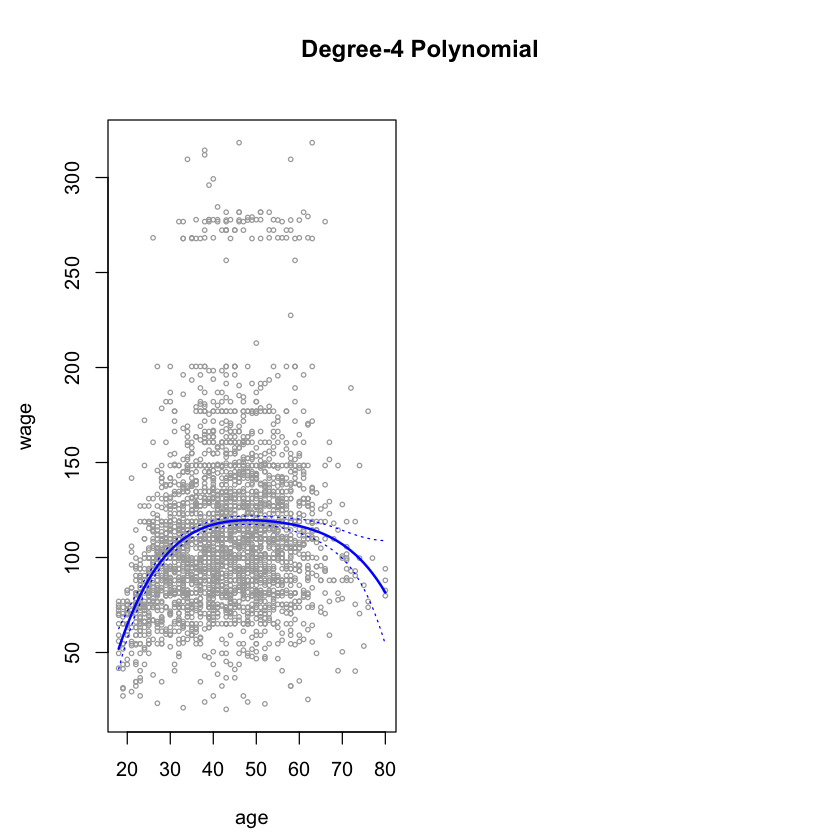

In [7]:
par(mfrow = c(1, 2), mar = c(4.5, 4.5, 1, 1),
    oma = c(0, 0, 4, 0))
plot(age, wage, xlim = agelims, cex = .5, col = "darkgrey")
title("Degree-4 Polynomial", outer = T)
lines(age.grid, preds$fit, lwd = 2, col = "blue")
matlines(age.grid, se.bands, lwd = 1, col = "blue", lty = 3)

Here the `mar` and `oma` arguments to `par()` allow us to control the margins of the plot, and the `title()` function creates a figure title that spans both subplots.

We mentioned earlier that whether or not an orthogonal set of basis functions is produced in the `poly()` function will not affect the model obtained in a meaningful way. What do we mean by this? The fitted values obtained in either case are
identical:

In [8]:
preds2 <- predict(fit2, newdata = list(age = age.grid),
    se = TRUE)
max(abs(preds$fit - preds2$fit))

[1] 1.641354e-12

In performing a polynomial regression we must decide on the degree of
the polynomial to use. One way to do this is by using hypothesis
tests. We now fit models ranging from linear to a degree-5 polynomial
and seek to determine the simplest model which is sufficient to
explain the relationship 
between `wage` and `age`. We use the
`anova()` function, which performs an \define{analysis of
  variance} (ANOVA, using an F-test) in order to test the null
hypothesis that a model $\mathcal{M}_1$ is sufficient to explain the
data against the alternative hypothesis that a more complex model
$\mathcal{M}_2$ is required. In order to use the `anova()`
function, $\mathcal{M}_1$ and $\mathcal{M}_2$ must be *nested*
models: the predictors in $\mathcal{M}_1$ must be a subset of the
predictors in $\mathcal{M}_2$. In this case, we fit five different
models and sequentially compare the simpler model to the more complex
model.

In [9]:
fit.1 <- lm(wage ~ age, data = Wage)
fit.2 <- lm(wage ~ poly(age, 2), data = Wage)
fit.3 <- lm(wage ~ poly(age, 3), data = Wage)
fit.4 <- lm(wage ~ poly(age, 4), data = Wage)
fit.5 <- lm(wage ~ poly(age, 5), data = Wage)
anova(fit.1, fit.2, fit.3, fit.4, fit.5)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2998,5022216,NA,NA,NA,NA
2,2997,4793430,1,228786.010,143.5931074,2.367734e-32
3,2996,4777674,1,15755.694,9.8887559,1.679213e-03
4,2995,4771604,1,6070.152,3.8098134,5.104623e-02
5,2994,4770322,1,1282.563,0.8049758,3.696820e-01


The p-value comparing the linear `Model 1` to the quadratic
`Model 2` is essentially zero ($<$$10^{-15}$), indicating that a linear
fit is not sufficient. Similarly the p-value comparing the quadratic
 `Model 2` to the cubic `Model 3` is very low ($0.0017$), so
the quadratic fit is also insufficient. The p-value comparing the
cubic and degree-4 polynomials, `Model 3` and `Model 4`, is approximately $5\,\%$
while the degree-5 polynomial `Model 5` seems unnecessary because its
p-value is $0.37$. Hence, either a cubic or a quartic
polynomial appear to provide a reasonable fit to the data, but lower-
or higher-order models are not justified.

In this case, instead of using the `anova()` function, we could have obtained these p-values more succinctly by exploiting the fact that `poly()` creates orthogonal polynomials.

In [10]:
coef(summary(fit.5))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),111.70361,0.7287647,153.2780243,0.000000e+00
"poly(age, 5)1",447.06785,39.9160847,11.2001930,1.491111e-28
"poly(age, 5)2",-478.31581,39.9160847,-11.9830341,2.367734e-32
"poly(age, 5)3",125.52169,39.9160847,3.1446392,1.679213e-03
"poly(age, 5)4",-77.91118,39.9160847,-1.9518743,5.104623e-02
"poly(age, 5)5",-35.81289,39.9160847,-0.8972045,3.696820e-01


Notice that the p-values are the same, and in fact the square of the  $t$-statistics are equal to the F-statistics from the `anova()` function; for example:

In [11]:
(-11.983)^2

[1] 143.5923

However, the ANOVA method works whether or not we used orthogonal polynomials; it also works when we have other terms in the model as well. For example, we can use `anova()` to compare these three models:

In [12]:
fit.1 <- lm(wage ~ education + age, data = Wage)
fit.2 <- lm(wage ~ education + poly(age, 2), data = Wage)
fit.3 <- lm(wage ~ education + poly(age, 3), data = Wage)
anova(fit.1, fit.2, fit.3)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2994,3867992,NA,NA,NA,NA
2,2993,3725395,1,142597.10,114.696898,2.728971e-26
3,2992,3719809,1,5586.66,4.493588,3.410431e-02


As an alternative to using hypothesis tests and ANOVA, we could choose the polynomial degree using  cross-validation, as discussed in Chapter 5.

Next we consider the task of predicting whether an individual earns more than $$250{,}000$ per year. We proceed much as before, except that first we create the appropriate response vector, and then apply the `glm()` function using `family = "binomial"` in order to fit a polynomial logistic regression model.

In [13]:
fit <- glm(I(wage > 250) ~ poly(age, 4), data = Wage,
    family = binomial)

Note that we again use the wrapper `I()` to create this binary response variable on the fly. The expression `wage > 250` evaluates to a logical variable containing `TRUE`s and `FALSE`s, which `glm()` coerces to binary by setting the `TRUE`s to 1 and the `FALSE`s to 0.

Once again, we make predictions using the `predict()` function.

In [14]:
preds <- predict(fit, newdata = list(age = age.grid), se = T)

However, calculating the confidence intervals is slightly more involved than in the linear regression case.
The default prediction type for a `glm()` model
is `type = "link"`, which is what we use here.  This means we get
predictions for the *logit* , or log-odds: that is, we have fit a model of the form
\[
\log\left(\frac{\Pr(Y=1|X)}{1-\Pr(Y=1|X)}\right)=X\beta,
\]
 and the predictions given are of the form $X\hat\beta$.  The  standard errors given are also for $X \hat\beta$. In order to obtain confidence intervals for $\Pr(Y=1|X)$, we use the transformation
\[
\Pr(Y=1|X)=\frac{\exp(X\beta)}{1+\exp(X\beta)}.
\]

In [15]:
pfit <- exp(preds$fit) / (1 + exp(preds$fit))
se.bands.logit <- cbind(preds$fit + 2 * preds$se.fit,
    preds$fit - 2 * preds$se.fit)
se.bands <- exp(se.bands.logit) / (1 + exp(se.bands.logit))

Note that we could have directly computed the probabilities by selecting the `type = "response"` option in the `predict()` function.

In [16]:
preds <- predict(fit, newdata = list(age = age.grid),
    type = "response", se = T)

However, the corresponding confidence intervals would not have been sensible because we would end up with negative probabilities!

Finally, the right-hand plot from Figure 7.1 was made as follows:

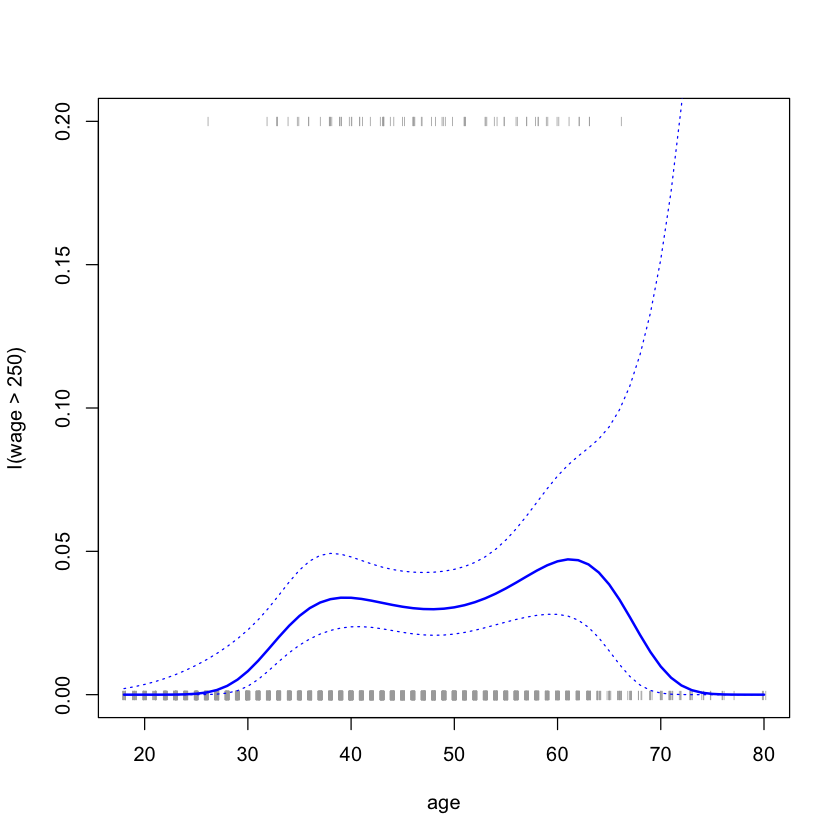

In [17]:
plot(age, I(wage > 250), xlim = agelims, type = "n",
    ylim = c(0, .2))
points(jitter(age), I((wage > 250) / 5), cex = .5, pch = "|", col = "darkgrey")
lines(age.grid, pfit, lwd = 2, col = "blue")
matlines(age.grid, se.bands, lwd = 1, col = "blue", lty = 3)

We have drawn  the `age` values corresponding to the observations with `wage` values above $250$ as gray marks on the top of the plot, and those with `wage` values below $250$ are shown as gray marks on the bottom of the plot. We used
the `jitter()` function to jitter the `age` values a bit so that observations with the same `age` value do not cover each other up. This is often called a .

In order to fit a step function, as discussed in Section 7.2, we use the `cut()` function.

In [18]:
table(cut(age, 4))
fit <- lm(wage ~ cut(age, 4), data = Wage)
coef(summary(fit))


(17.9,33.5]   (33.5,49]   (49,64.5] (64.5,80.1] 
        750        1399         779          72 

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),94.158392,1.476069,63.789970,0.000000e+00
"cut(age, 4)(33.5,49]",24.053491,1.829431,13.148074,1.982315e-38
"cut(age, 4)(49,64.5]",23.664559,2.067958,11.443444,1.040750e-29
"cut(age, 4)(64.5,80.1]",7.640592,4.987424,1.531972,1.256350e-01


Here `cut()` automatically picked the cutpoints at $33.5$, $49$, and $64.5$~years of age. We could also have specified our own cutpoints directly using the `breaks` option.
The function `cut()` returns an ordered categorical variable ; the `lm()` function then creates a set of dummy variables for use in the regression. The `age < 33.5` category is left out, so the intercept coefficient of $$94{,}160$ can be interpreted as the average salary for those under $33.5$~years of age, and the other coefficients can be interpreted as the average additional salary for those in the other age groups.
We can produce predictions and plots just as we did in the case of the polynomial fit.


In order to fit regression splines in `R`, we use the `splines` library.
In Section 7.4, we saw that regression
splines can be fit by constructing an appropriate matrix of basis functions.
The
 `bs()` function generates the entire matrix of basis functions for splines with the specified set of knots. By default, cubic splines are produced.
Fitting `wage` to `age` using a regression spline is simple:

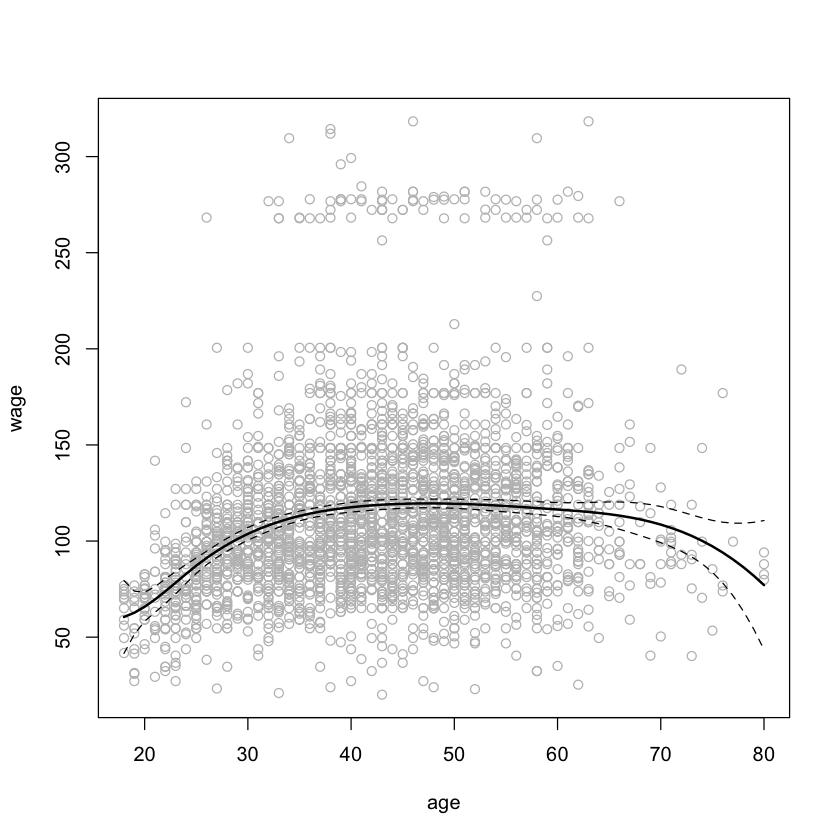

In [19]:
library(splines)
fit <- lm(wage ~ bs(age, knots = c(25, 40, 60)), data = Wage)
pred <- predict(fit, newdata = list(age = age.grid), se = T)
plot(age, wage, col = "gray")
lines(age.grid, pred$fit, lwd = 2)
lines(age.grid, pred$fit + 2 * pred$se, lty = "dashed")
lines(age.grid, pred$fit - 2 * pred$se, lty = "dashed")

Here we have prespecified knots at ages $25$, $40$, and $60$. This produces a spline with six basis functions. (Recall that a cubic spline with three knots has seven degrees of freedom; these degrees of freedom are used up by an intercept, plus six basis functions.) We could also use the `df` option to produce a spline with knots at uniform quantiles
of the data.

In [20]:
dim(bs(age, knots = c(25, 40, 60)))
dim(bs(age, df = 6))
attr(bs(age, df = 6), "knots")

[1] 3000    6

[1] 3000    6

25%   50%   75% 
33.75 42.00 51.00

In this case `R` chooses knots at ages $33.8, 42.0$, and $51.0$, which correspond to the 25th, 50th, and 75th percentiles of `age`. The function `bs()` also has a `degree` argument, so we can fit splines of any degree, rather than the default degree of 3 (which yields a cubic spline).  

In order to instead fit a natural spline, we use the `ns()` function. 
Here we fit a natural spline with four degrees of freedom.

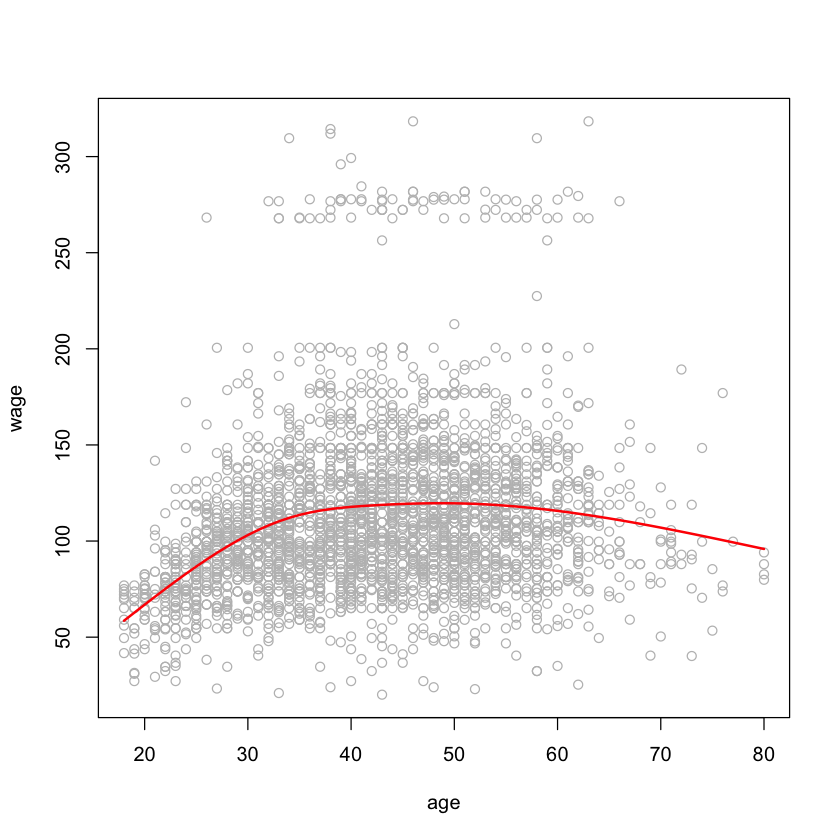

In [21]:
fit2 <- lm(wage ~ ns(age, df = 4), data = Wage)
pred2 <- predict(fit2, newdata = list(age = age.grid),
     se = T)
plot(age, wage, col = "gray")
lines(age.grid, pred2$fit, col = "red", lwd = 2)

As with the `bs()` function, we could instead specify the knots directly using the `knots` option.

  In order to fit a smoothing spline, we use
the `smooth.spline()` function.
Figure 7.8  was produced with the following
code:

Warning message in smooth.spline(age, wage, cv = TRUE):
“cross-validation with non-unique 'x' values seems doubtful”


[1] 6.794596

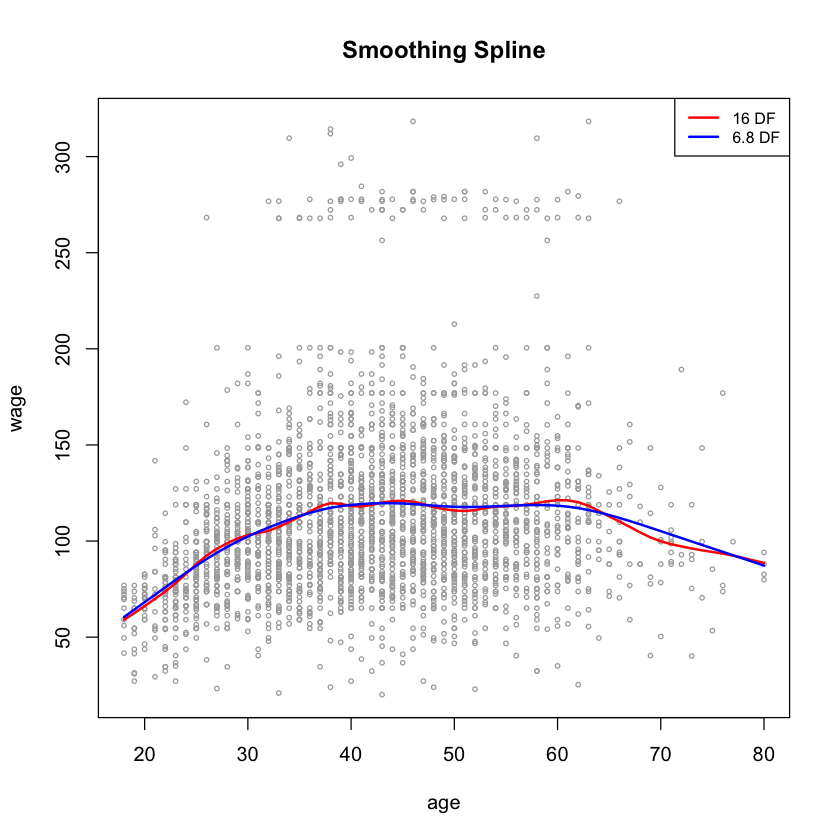

In [22]:
plot(age, wage, xlim = agelims, cex = .5, col = "darkgrey")
title("Smoothing Spline")
fit <- smooth.spline(age, wage, df = 16)
fit2 <- smooth.spline(age, wage, cv = TRUE)
fit2$df
lines(fit, col = "red", lwd = 2)
lines(fit2, col = "blue", lwd = 2)
legend("topright", legend = c("16 DF", "6.8 DF"),
    col = c("red", "blue"), lty = 1, lwd = 2, cex = .8)

Notice that in the first call to `smooth.spline()`, we specified `df = 16`. The function then  determines which value of $\lambda$  leads to $16$ degrees of freedom.
 In the second call to `smooth.spline()`, we select the smoothness level by cross-validation;
 this results in a value of $\lambda$ that yields 6.8 degrees of freedom.

In order to perform local regression, we use the `loess()` function. 

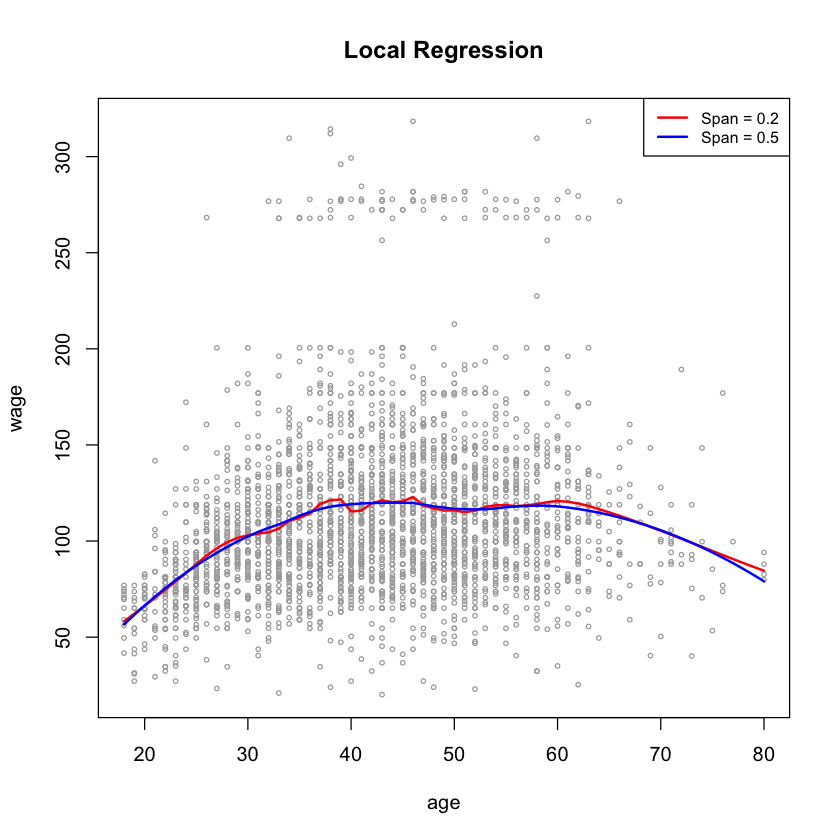

In [23]:
plot(age, wage, xlim = agelims, cex = .5, col = "darkgrey")
title("Local Regression")
fit <- loess(wage ~ age, span = .2, data = Wage)
fit2 <- loess(wage ~ age, span = .5, data = Wage)
lines(age.grid, predict(fit, data.frame(age = age.grid)),
    col = "red", lwd = 2)
lines(age.grid, predict(fit2, data.frame(age = age.grid)),
    col = "blue", lwd = 2)
legend("topright", legend = c("Span = 0.2", "Span = 0.5"),
    col = c("red", "blue"), lty = 1, lwd = 2, cex = .8)

Here we have performed local linear regression using spans of $0.2$ and $0.5$: that is, each neighborhood consists of 20\,\% or 50\,\% of the observations. The larger the span, the smoother the fit.
The `locfit` library can also be used for fitting local regression models in `R`.

## GAMs

We now fit a GAM to predict `wage` using natural spline functions of `lyear` and `age`,  treating `education` as a qualitative predictor, as in (7.16). Since this is just a big linear regression model using an appropriate choice of basis functions, we can simply do this using the `lm()` function.

In [24]:
gam1 <- lm(wage ~ ns(year, 4) + ns(age, 5) + education,
    data = Wage)

We now fit the model (7.16) using smoothing splines rather than natural splines.  In order to fit more general sorts of GAMs, using smoothing splines or other components that cannot be expressed in terms of basis functions and then fit using least squares regression, we will need to use the `gam` library in `R`.

The `s()` function, which is part of the `gam` library, is used to indicate that we would like to use a smoothing spline. We specify that the function of `lyear` should have $4$ degrees of freedom, and that the function of `age` will have $5$ degrees of freedom. Since `education` is qualitative, we leave it as is, and it is converted into four dummy variables. We use the `gam()` function in order to fit a GAM using these components.
 All of the terms in (7.16) are fit simultaneously, taking each other into account to explain the response.

In [26]:
#install.packages('gam')

In [27]:
library(gam)
gam.m3 <- gam(wage ~ s(year, 4) + s(age, 5) + education,
    data = Wage)

Loading required package: foreach

Loaded gam 1.22




In order to produce  Figure 7.12, we simply call the `plot()` function:

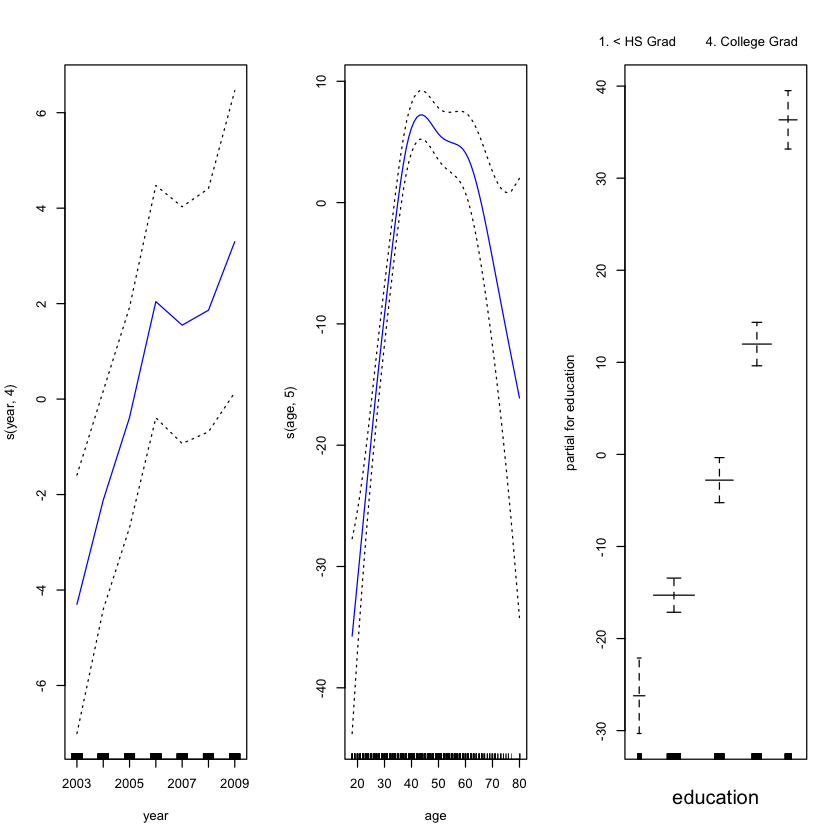

In [28]:
par(mfrow = c(1, 3))
plot(gam.m3, se = TRUE, col = "blue")

The generic `plot()` function recognizes that `gam.m3` is an
object of class `Gam`, and invokes the appropriate
`plot.Gam()` method.  Conveniently, even though
  `gam1` is not of class `Gam` but rather of class `lm`, we can {\em
  still} use `plot.Gam()` on it.  Figure 7.11 was produced using the following expression:

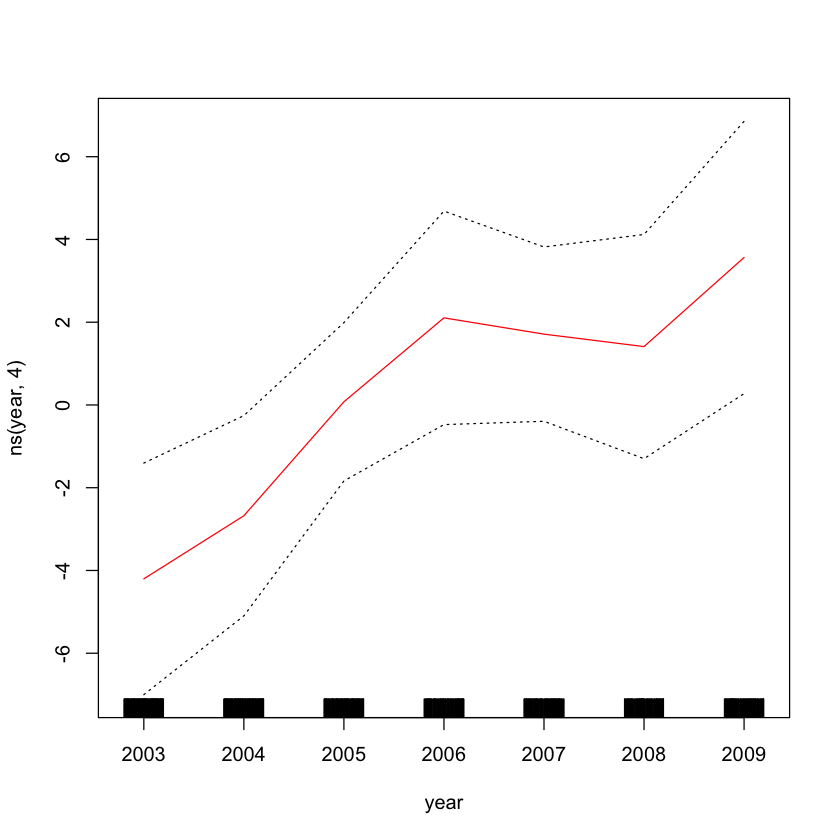

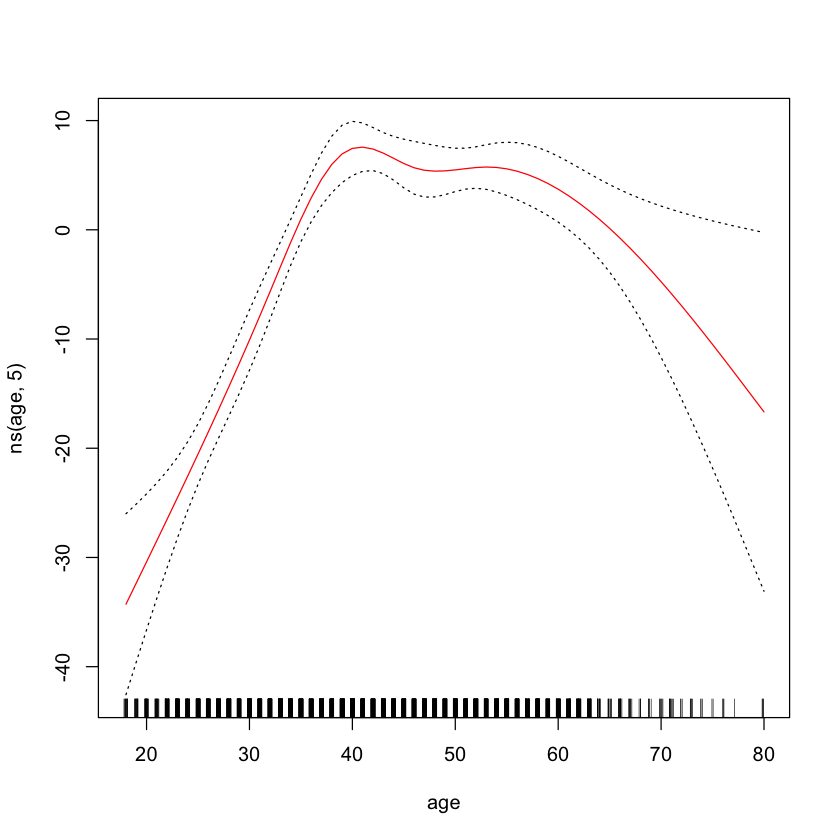

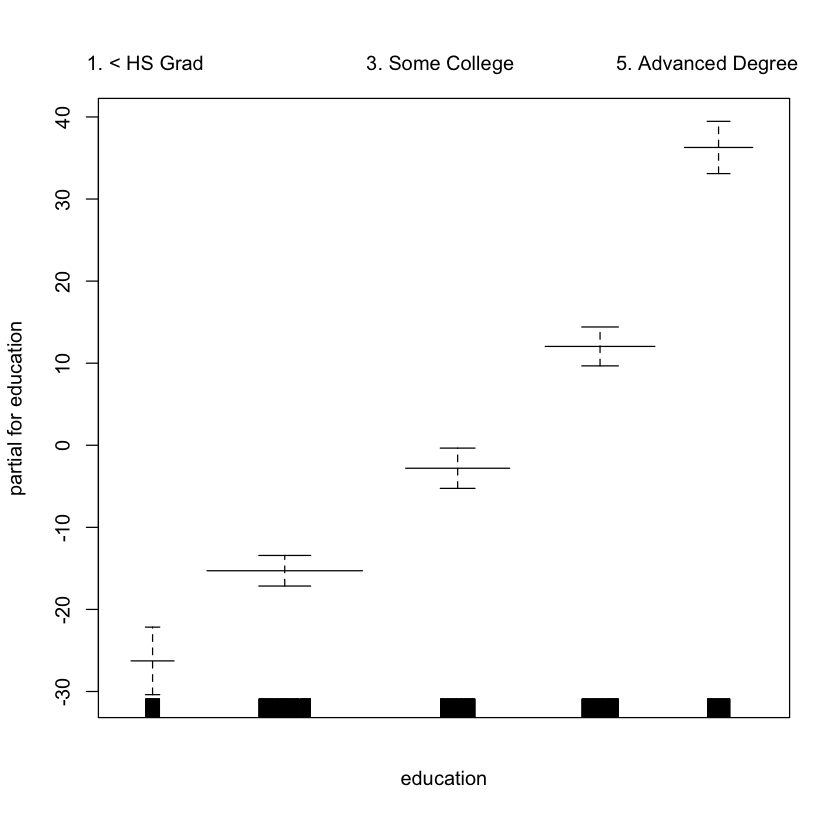

In [29]:
plot.Gam(gam1, se = TRUE, col = "red")

Notice here we had to use `plot.Gam()` rather than the *generic* `plot()` function.

In these plots, the function of `lyear` looks rather linear. We can perform a series of ANOVA tests in order to determine which of these three models is best:  a GAM that excludes `lyear` ($\mathcal{M}_1$),  a GAM that uses a linear function of `lyear` ($\mathcal{M}_2$), or  a GAM that uses a spline function
of `lyear` ($\mathcal{M}_3$).

In [30]:
gam.m1 <- gam(wage ~ s(age, 5) + education, data = Wage)
gam.m2 <- gam(wage ~ year + s(age, 5) + education,
    data = Wage)
anova(gam.m1, gam.m2, gam.m3, test = "F")

,Resid. Df,Resid. Dev,Df,Deviance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2990,3711731,NA,NA,NA,NA
2,2989,3693842,1.000000,17889.243,14.477130,0.0001447167
3,2986,3689770,2.999989,4071.134,1.098212,0.3485661430


We find that there is compelling evidence that a GAM with a linear function of `lyear` is better than a GAM that does not include `lyear` at all \hbox{(p-value\,=\,0.00014).} However, there is no evidence that a non-linear function of `lyear` is needed (p-value\,=\,0.349).
In other words, based on the results of this ANOVA, $\mathcal{M}_2$ is preferred.

The `summary()` function produces a summary of the gam fit.

In [31]:
summary(gam.m3)


Call: gam(formula = wage ~ s(year, 4) + s(age, 5) + education, data = Wage)
Deviance Residuals:
    Min      1Q  Median      3Q     Max 
-119.43  -19.70   -3.33   14.17  213.48 

(Dispersion Parameter for gaussian family taken to be 1235.69)

    Null Deviance: 5222086 on 2999 degrees of freedom
Residual Deviance: 3689770 on 2986 degrees of freedom
AIC: 29887.75 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
             Df  Sum Sq Mean Sq F value    Pr(>F)    
s(year, 4)    1   27162   27162  21.981 2.877e-06 ***
s(age, 5)     1  195338  195338 158.081 < 2.2e-16 ***
education     4 1069726  267432 216.423 < 2.2e-16 ***
Residuals  2986 3689770    1236                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Anova for Nonparametric Effects
            Npar Df Npar F  Pr(F)    
(Intercept)                          
s(year, 4)        3  1.086 0.3537    
s(age, 5)         4 32.380 <2e-16 ***
education                            
--

The ``Anova for Parametric Effects" p-values clearly demonstrate that `year`, `age`, and `education` are all highly statistically significant, even when only assuming a linear relationship. Alternatively, the ``Anova for Nonparametric Effects" p-values for `year` and `age` correspond to a null hypothesis of a linear relationship versus the alternative of a non-linear relationship. The large p-value for `year` reinforces our conclusion from the ANOVA test that a linear function is adequate for this term. However, there is very clear evidence that a non-linear term is required for `age`.

We can make predictions
using the `predict()` method for the class `Gam`.
 Here we make predictions on the training set.

In [32]:
preds <- predict(gam.m2, newdata = Wage)

We can also use local regression fits as building blocks in a GAM, using the `lo()` function.

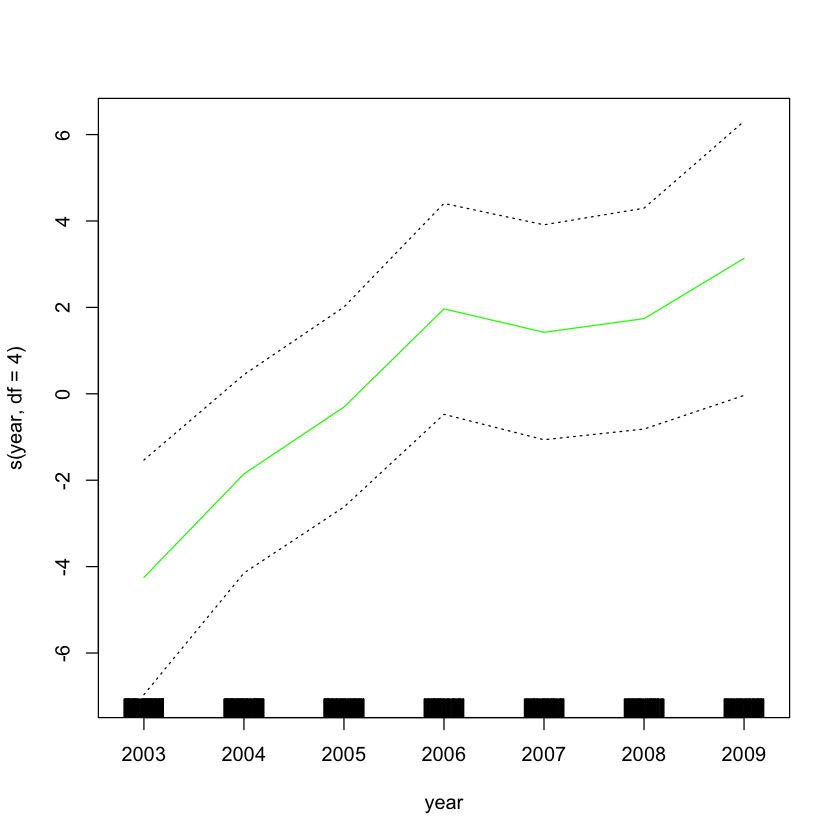

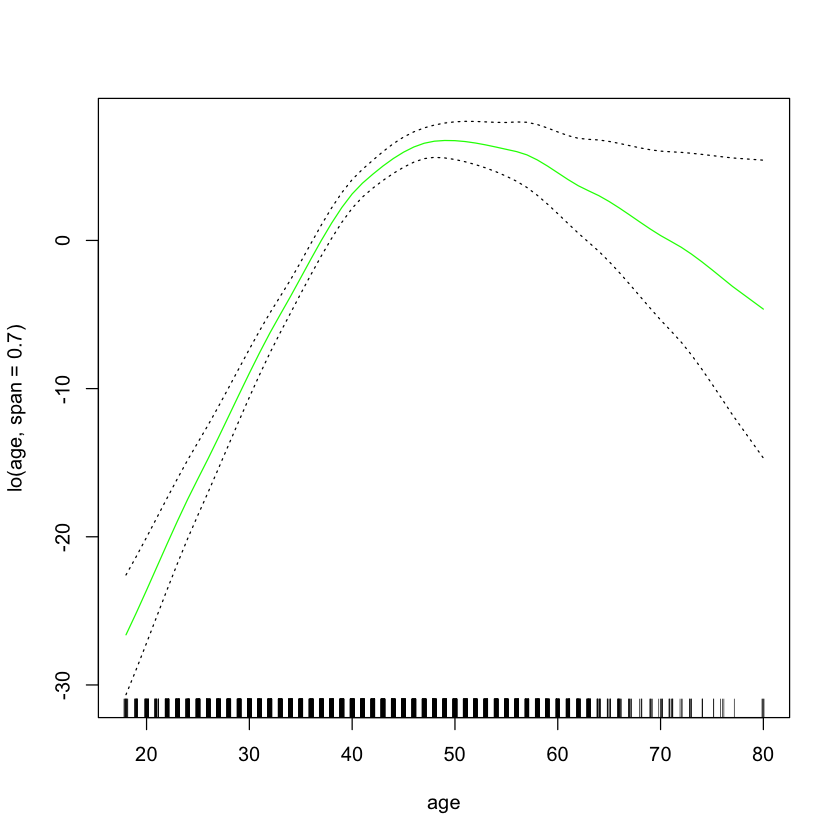

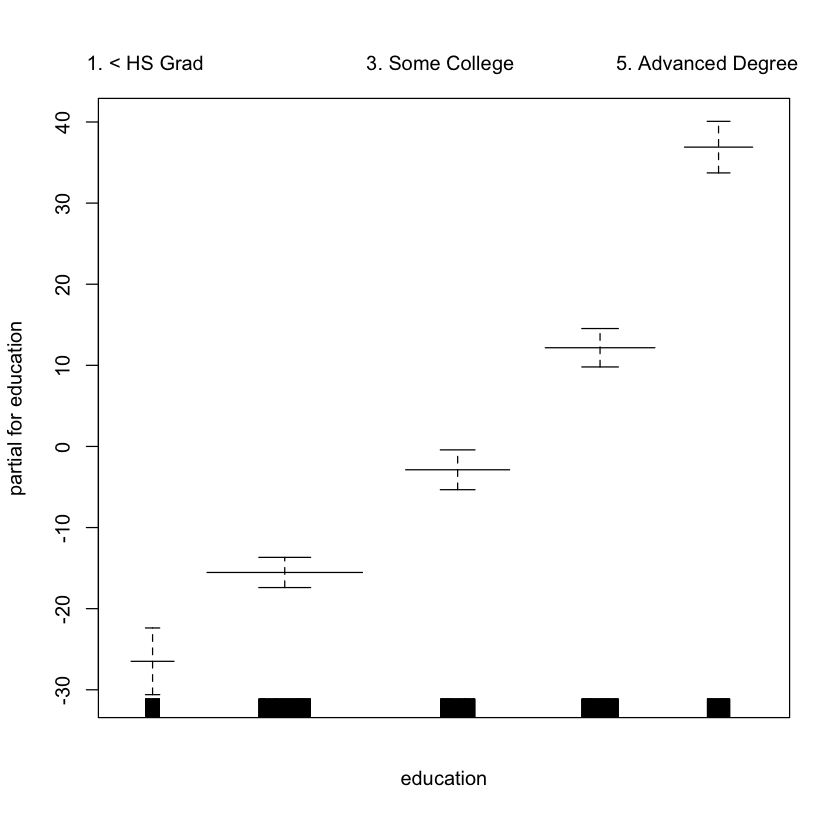

In [33]:
gam.lo <- gam(
    wage ~ s(year, df = 4) + lo(age, span = 0.7) + education,
    data = Wage
  )
plot.Gam(gam.lo, se = TRUE, col = "green")

Here we have used local regression for the `age` term, with a span of
$0.7$.
We can also use the `lo()` function to create interactions before calling the `gam()` function. For example,

In [34]:
gam.lo.i <- gam(wage ~ lo(year, age, span = 0.5) + education,
    data = Wage)

Warning message in lo.wam(x, z, wz, fit$smooth, which, fit$smooth.frame, bf.maxit, :
“liv too small.    (Discovered by lowesd)”
Warning message in lo.wam(x, z, wz, fit$smooth, which, fit$smooth.frame, bf.maxit, :
“lv too small.     (Discovered by lowesd)”
Warning message in lo.wam(x, z, wz, fit$smooth, which, fit$smooth.frame, bf.maxit, :
“liv too small.    (Discovered by lowesd)”
Warning message in lo.wam(x, z, wz, fit$smooth, which, fit$smooth.frame, bf.maxit, :
“lv too small.     (Discovered by lowesd)”


fits a two-term model, in which the first term is an interaction between `lyear` and `age`, fit by a local regression surface. We can plot the resulting two-dimensional surface if we first install the `akima` package.

In [36]:
#install.packages('akima')
#install.packages('interp')

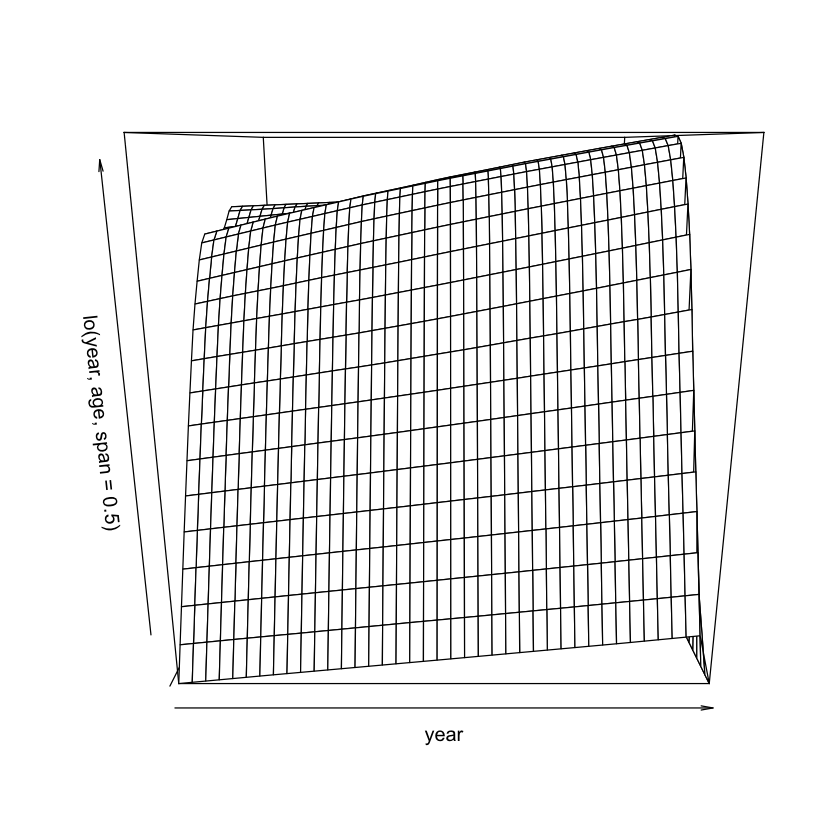

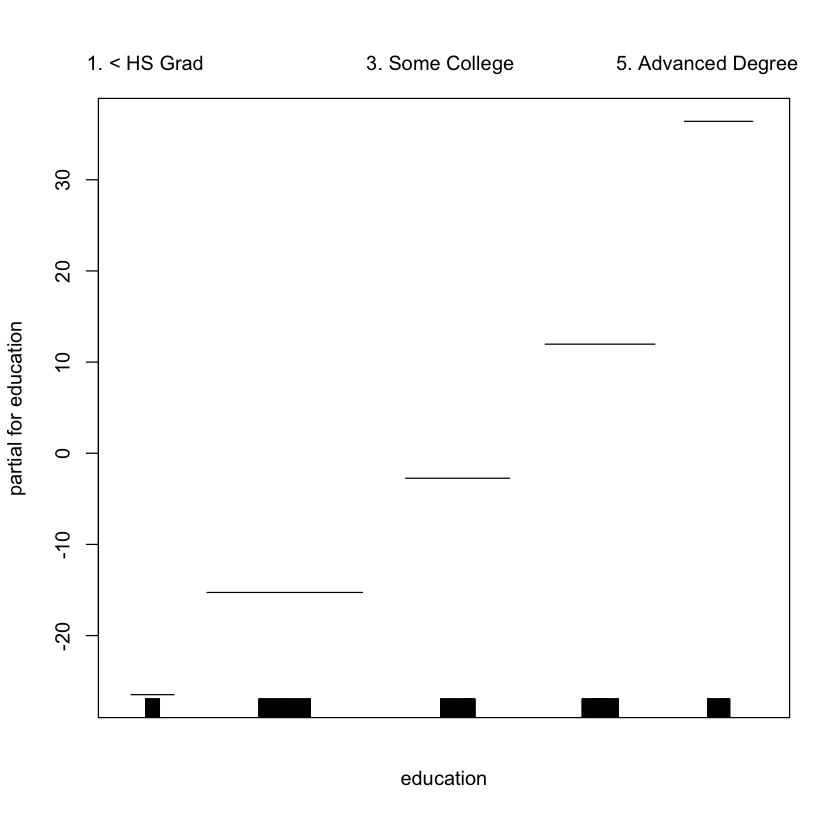

In [38]:
library(akima)
plot(gam.lo.i)

In order to fit a logistic regression GAM, we once again use the `I()` function in constructing the binary response variable, and set `family=binomial`.

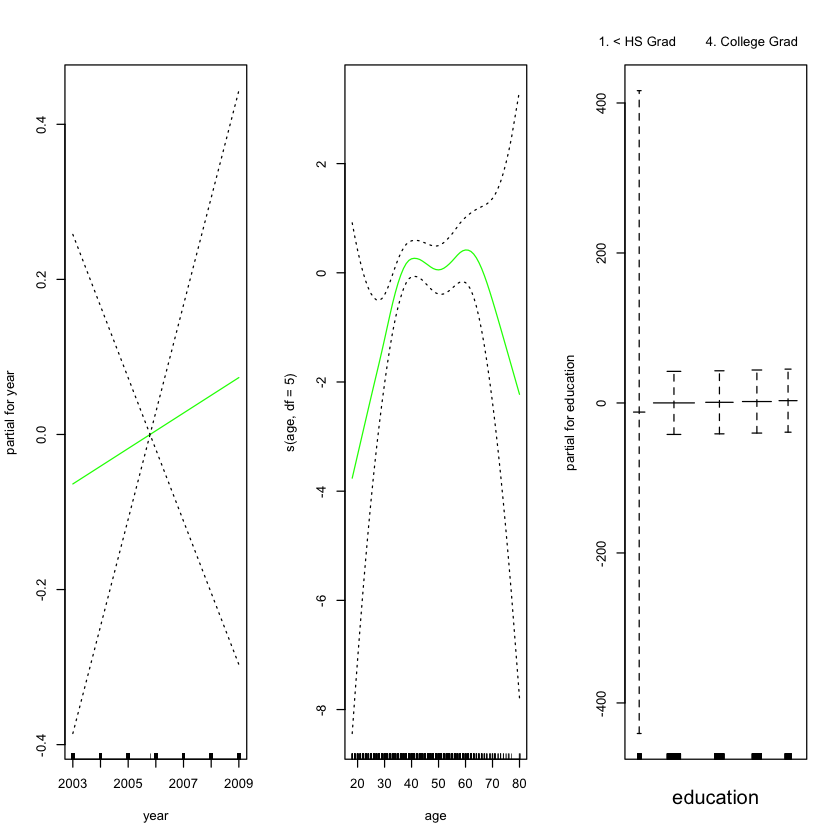

In [39]:
gam.lr <- gam(
    I(wage > 250) ~ year + s(age, df = 5) + education,
    family = binomial, data = Wage
  )
par(mfrow = c(1, 3))
plot(gam.lr, se = T, col = "green")

It is easy to see that there are no high earners in the `< HS` category:

In [40]:
table(education, I(wage > 250))

                    
education            FALSE TRUE
  1. < HS Grad         268    0
  2. HS Grad           966    5
  3. Some College      643    7
  4. College Grad      663   22
  5. Advanced Degree   381   45

Hence, we fit a logistic regression GAM using all but this category. This provides more sensible results.

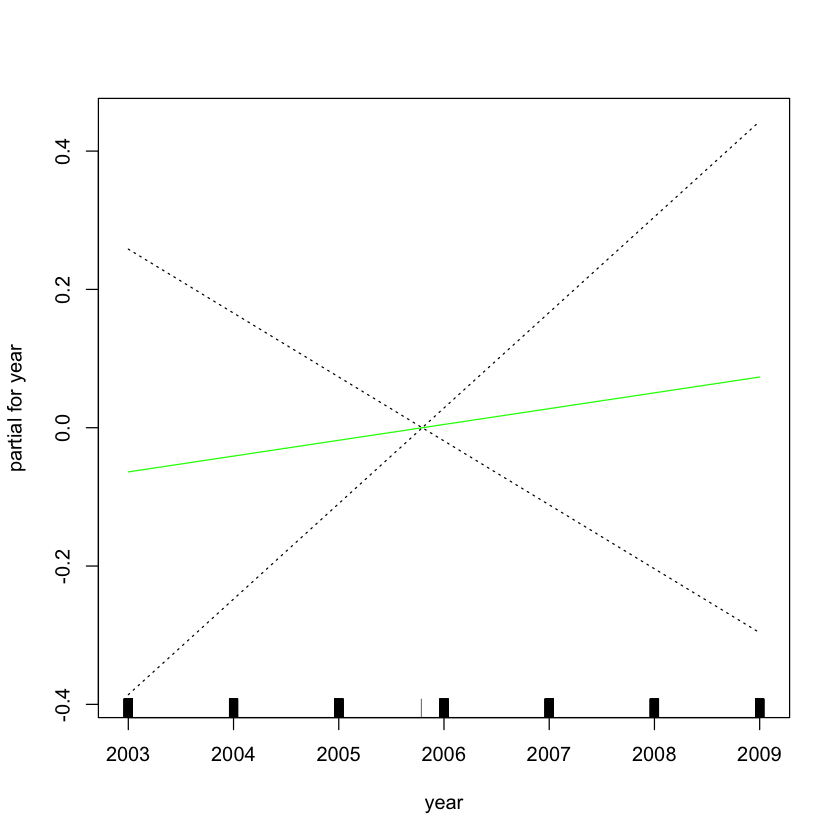

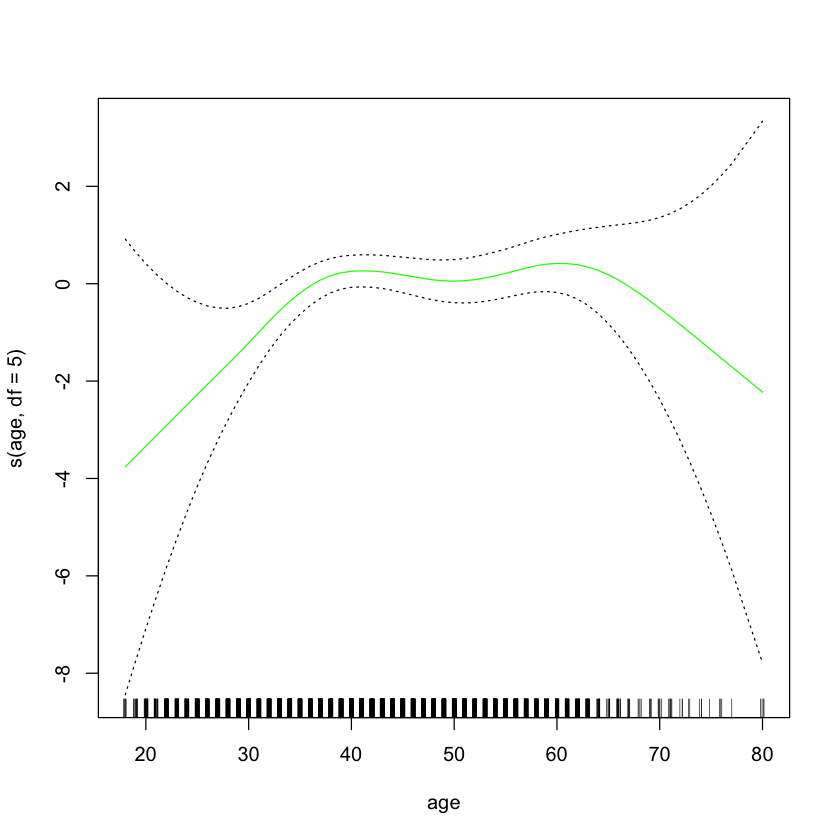

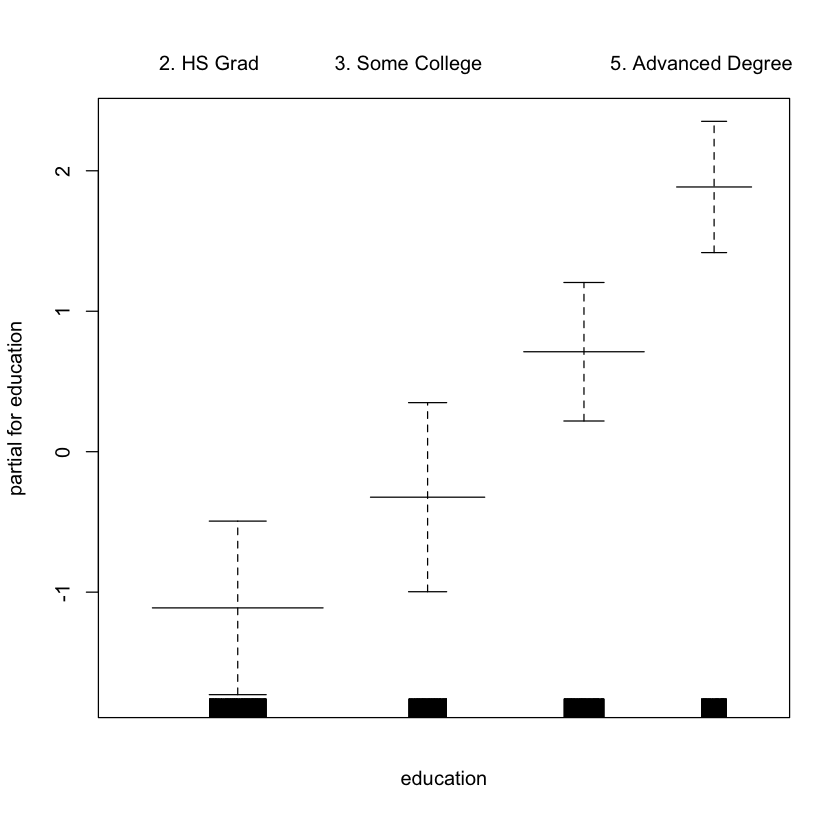

In [41]:
gam.lr.s <- gam(
    I(wage > 250) ~ year + s(age, df = 5) + education,
    family = binomial, data = Wage,
    subset = (education != "1. < HS Grad")
  )
plot(gam.lr.s, se = T, col = "green")